# Age estimation using a CNN and UTKFace

The UTKFace dataset die hier gebruikt wordt is op de volgende locatie te vinden [link](https://susanqq.github.io/UTKFace/). The 3 datasets worden gedownload als UTKFace folder part1, part2, part3. 

In [101]:
import os # For directory and file path operations
import re # For regex pattern matching

import matplotlib.pyplot as plt
import numpy as np

# Basic CNN setup and training
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img

## Loading the image data and extracting the features from the file name

Zorg ervoor dat je een map hebt waar deze code in staat, met daarin de map UTKFace waar je part 1, part 2 en part 3 instopt die je hiervoor hebt gedownload!

In [102]:
#Path to the UTKFace dataset
utkface_dir = 'data'

image_paths = []
ages = []
genders = []
races = []

#Regex to extract labels from filename
pattern = re.compile(r'^(\d+)_(\d+)_(\d+)_')

for part in ['part1', 'part2', 'part3']:
    part_dir = os.path.join(utkface_dir, part)
    if not os.path.isdir(part_dir):
        continue
    for fname in os.listdir(part_dir):
        match = pattern.match(fname)
        if match:
            age, gender, race = map(int, match.groups())
            image_paths.append(os.path.join(part_dir, fname))
            ages.append(age)
            genders.append(gender)
            races.append(race)

print(f'Total images loaded: {len(image_paths)}')
if image_paths:
    print(f'Example: {image_paths[0]}, Age: {ages[0]}, Gender: {genders[0]}, Race: {races[0]}')

Total images loaded: 24104
Example: data\part1\100_1_0_20170110183726390.jpg, Age: 100, Gender: 1, Race: 0


## Data verkenning (basis)

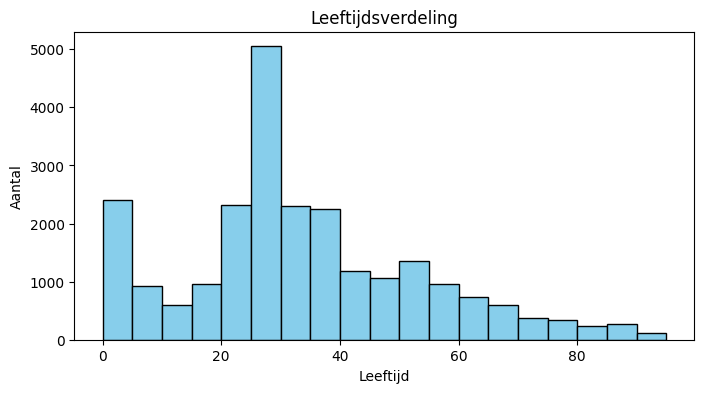

In [103]:
#Verdeling van de leeftijden plotten

plt.figure(figsize=(8,4))
plt.hist(ages, bins=range(0, 100, 5), color='skyblue', edgecolor='black')
plt.title('Leeftijdsverdeling')
plt.xlabel('Leeftijd')
plt.ylabel('Aantal')
plt.show()

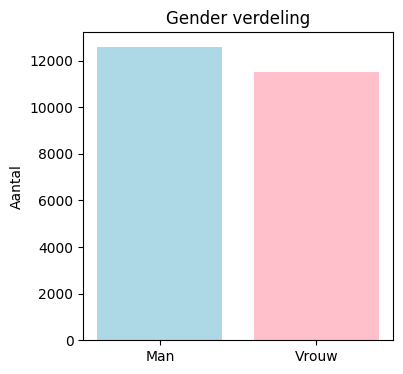

In [104]:
#Gender verdeling plotten

plt.figure(figsize=(4,4))
plt.bar(['Man', 'Vrouw'], [genders.count(0), genders.count(1)], color=['lightblue', 'pink'])
plt.title('Gender verdeling')
plt.ylabel('Aantal')
plt.show()

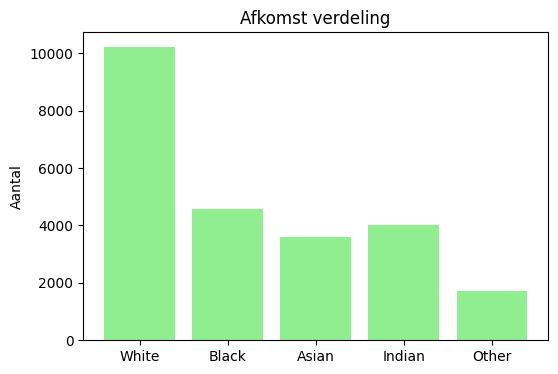

In [105]:
# Afkomst verdeling plotten

race_labels = ['White', 'Black', 'Asian', 'Indian', 'Other']
race_counts = [races.count(i) for i in range(len(race_labels))]
plt.figure(figsize=(6,4))
plt.bar(race_labels, race_counts, color='lightgreen')
plt.title('Afkomst verdeling')
plt.ylabel('Aantal')
plt.show()

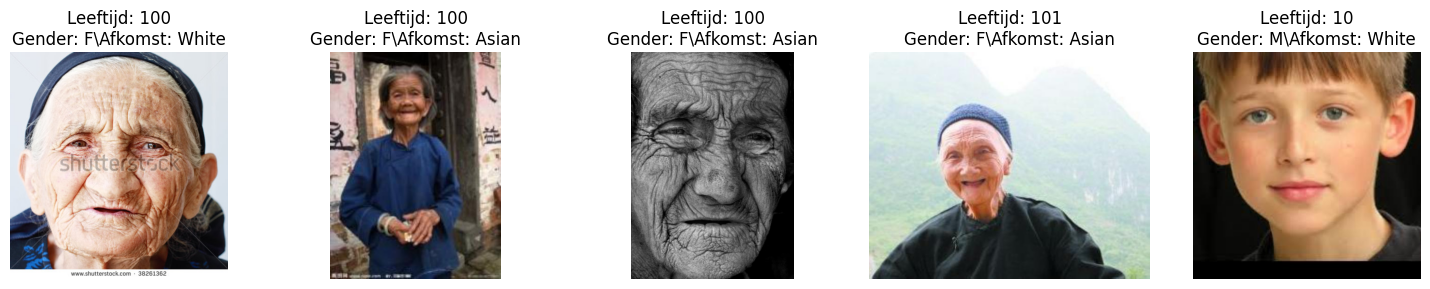

In [106]:
#Laat een paar voorbeelden zien met labels

import matplotlib.image as mpimg
fig, axes = plt.subplots(1, 5, figsize=(15,3))
for i, ax in enumerate(axes):
    img = mpimg.imread(image_paths[i])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Leeftijd: {ages[i]}\nGender: {"M" if genders[i]==0 else "F"}\Afkomst: {race_labels[races[i]]}')
plt.tight_layout()
plt.show()

In [107]:
print(len(image_paths))

24104


In [108]:
#Kleinere set maken voor training
subset_size = len(image_paths)  #totaal aantal afbeeldingen is 23701, dus je kan dit aantal aanpassen naar een kleiner aantal als je computer dit niet trekt.
np.random.seed(42) #Dit kan je gelijk houden
indices = np.random.choice(len(image_paths), size=subset_size, replace=False)

image_paths = [image_paths[i] for i in indices]
ages = [ages[i] for i in indices]
genders = [genders[i] for i in indices]
races = [races[i] for i in indices]

print(f'Using a subset of {subset_size} images.')

Using a subset of 24104 images.


## Load and preprocess


In [109]:
#Parameters
img_size = 112  #Hier mag je mee spelen, maar hoe groter hoe zwaarder voor je computer


#Laad de afbeeldingen 
X = []
for path in image_paths:
    img = load_img(path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0
    X.append(img)
X = np.array(X)
y = np.array(ages)  #Gebruik leeftijd als target variabele


#Split de data in een train en validatieset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) #Waardes niet aanpassen

## Opties voor het bouwen en tweaken van een CNN voor Age Estimation

Bij het bouwen van een Convolutional Neural Network (CNN) heb je veel keuzes in lagen, functies en parameters. Hieronder een overzicht van de belangrijkste opties.

---

### 1. Convolutional Layers (Conv2D)
- **Wat**: Leren van filters/kernels die patronen in afbeeldingen oppikken (randen, vormen, texturen).
- **Belangrijkste parameters**:
  - `filters`: Aantal kernels (meer filters = meer features, maar ook meer rekenkracht nodig).
  - `kernel_size`: Grootte van de filter (bijv. `(3,3)` is standaard, `(5,5)` pakt grotere patronen).
  - `strides`: Hoeveel pixels de kernel opschuift. `(1,1)` = overlappend, `(2,2)` = sneller maar minder nauwkeurig.
  - `padding`: 
    - `"valid"` → geen padding (afbeelding wordt kleiner).
    - `"same"` → padding zodat output dezelfde spatial size behoudt.
  - `activation`: Vaak `"relu"`, maar `"leakyrelu"` of `"elu"` kunnen helpen bij dode neuronen.

---

### 2. Pooling Layers
- **MaxPooling2D**: Neemt de grootste waarde in een region (populair, behoudt de sterkste features).
- **AveragePooling2D**: Neemt het gemiddelde (soms nuttig voor regressietaken).
- **GlobalAveragePooling2D / GlobalMaxPooling2D**: Gemiddelt of pakt max over de hele feature map → vaak alternatief voor `Flatten`.

Parameters:
- `pool_size`: Meestal `(2,2)`.
- `strides`: Stapgrootte, vaak gelijk aan pool_size.

---

### 3. Normalization Layers
- **BatchNormalization**: Normaliseert activaties per batch → stabielere en snellere training.
- **LayerNormalization / InstanceNormalization**: Varianten die soms beter werken in kleinere batches of bij specifieke taken.

---

### 4. Regularization Layers
- **Dropout**: Zet willekeurig neuronen uit tijdens training om overfitting te voorkomen.
  - `rate`: bv. `0.3` = 30% van de neuronen wordt gedropt.
- **L2 regularization (kernel_regularizer)**: Straft grote gewichten af → model blijft simpel.
- **Data Augmentation layers** (`RandomFlip`, `RandomRotation`, `RandomZoom`) helpen generalisatie.

---

### 5. Dense (Fully Connected) Layers
- **Wat**: Combineert features tot uiteindelijke voorspelling.
- **Belangrijkste parameters**:
  - `units`: Aantal neuronen.
  - `activation`: 
    - `"relu"` → standaard.
    - `"sigmoid"` → voor binaire classificatie.
    - `"softmax"` → voor multiclass classificatie.
    - `"linear"` → voor regressie (zoals leeftijd).

---

### 6. Activatiefuncties
- **ReLU**: Populair, snel, maar kan "dode neuronen" krijgen.
- **LeakyReLU**: Laat kleine negatieve waarden door → voorkomt dead neurons.
- **ELU / SELU**: Soepeler en soms sneller convergent.
- **Tanh / Sigmoid**: Zelden in hidden layers (vanwege vanishing gradients).
- **Linear**: Voor regressie-output (zoals leeftijd).

---

### 7. Optimalizers
- **SGD**: Simpel, soms langzaam.
- **Adam**: Meest gebruikt, adaptieve learning rate.
- **RMSProp**: Alternatief voor Adam, goed bij recurrente modellen.
- Belangrijkste parameters:
  - `learning_rate`: Essentieel om af te stemmen (te hoog = instabiliteit, te laag = traag).

---

### 8. Loss Functions (voor Age Estimation)
- **Mean Squared Error (MSE)**: Straft grote fouten zwaarder.
- **Mean Absolute Error (MAE)**: Minder gevoelig voor outliers.
- **Huber Loss**: Combineert MSE en MAE, robuust tegen outliers.

---

### 9. Andere nuttige lagen/technieken
- **Residual connections (ResNet-stijl)**: Helpt bij diepe netwerken.
- **SeparableConv2D**: Efficiënter, minder parameters (gebruikt in MobileNet).
- **DepthwiseConv2D**: Voor lichte modellen.
- **Attention modules**: Kunnen helpen focus te leggen op relevante gezichtsfeatures.
- **Flatten vs. GAP**: 
  - `Flatten()` geeft alle features als 1D-vector.
  - `GlobalAveragePooling2D()` geeft compacter resultaat en reduceert overfitting.

---

## Modellen trainen
Hier mogen jullie dus alles aanpassen, ik geef aan bij welke delen je niet mag aanpassen

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',      # what metric to watch
    patience=4,              # how many epochs to wait for improvement
    restore_best_weights=True  # go back to the best model
)

checkpoint = ModelCheckpoint(
    "best_age_model.h5",       # filename to save
    monitor="val_loss",
    save_best_only=True,
    mode="min"
)

#CNN layers (DEZE KAN JE AANPASSEN)
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(256),
    layers.LeakyReLU(alpha=0.1),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear')  #dit blijft 1 want we voorspellen 1 waarde (leeftijd)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 598.8026 - mae: 18.7862

302/302 ━━━━━━━━━━━━━━━━━━━━ 98s 319ms/step - loss: 479.3102 - mae: 16.7650 - val_loss: 421.4374 - val_mae: 16.7165
Epoch 2/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 385.5544 - mae: 15.1574

302/302 ━━━━━━━━━━━━━━━━━━━━ 97s 321ms/step - loss: 382.5743 - mae: 15.0654 - val_loss: 363.4326 - val_mae: 14.8902
Epoch 3/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 373.2746 - mae: 14.7975

302/302 ━━━━━━━━━━━━━━━━━━━━ 98s 323ms/step - loss: 359.3227 - mae: 14.5239 - val_loss: 342.4290 - val_mae: 13.9588
Epoch 4/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 328.4297 - mae: 13.8248

302/302 ━━━━━━━━━━━━━━━━━━━━ 97s 322ms/step - loss: 317.5761 - mae: 13.5806 - val_loss: 335.0587 - val_mae: 13.2962
Epoch 5/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 286.0812 - mae: 12.8629

302/302 ━━━━━━━━━━━━━━━━━━━━ 96s 319ms/step - loss: 287.4935 - mae: 12.8316 - val_loss: 290.2490 - val_mae: 13.2057
Epoch 6/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 269.6033 - mae: 12.4127

302/302 ━━━━━━━━━━━━━━━━━━━━ 95s 314ms/step - loss: 264.7355 - mae: 12.2098 - val_loss: 268.0161 - val_mae: 12.5053
Epoch 7/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 96s 317ms/step - loss: 237.4041 - mae: 11.4792 - val_loss: 283.2190 - val_mae: 11.9221
Epoch 8/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 224.7415 - mae: 11.1331

302/302 ━━━━━━━━━━━━━━━━━━━━ 96s 316ms/step - loss: 218.4326 - mae: 10.9849 - val_loss: 235.4352 - val_mae: 11.6339
Epoch 9/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 198.8810 - mae: 10.4297

302/302 ━━━━━━━━━━━━━━━━━━━━ 96s 317ms/step - loss: 200.6237 - mae: 10.5410 - val_loss: 212.1131 - val_mae: 10.3312
Epoch 10/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 96s 317ms/step - loss: 173.5607 - mae: 9.7712 - val_loss: 261.6290 - val_mae: 12.5618
Epoch 11/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 97s 322ms/step - loss: 156.3331 - mae: 9.2885 - val_loss: 218.0694 - val_mae: 10.2145
Epoch 12/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 128.2416 - mae: 8.4342

302/302 ━━━━━━━━━━━━━━━━━━━━ 96s 319ms/step - loss: 133.3412 - mae: 8.5737 - val_loss: 193.9661 - val_mae: 10.0927
Epoch 13/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 119.5027 - mae: 8.1589

302/302 ━━━━━━━━━━━━━━━━━━━━ 95s 314ms/step - loss: 117.7811 - mae: 8.1003 - val_loss: 188.6718 - val_mae: 9.8286
Epoch 14/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 95s 314ms/step - loss: 102.1060 - mae: 7.5662 - val_loss: 195.0754 - val_mae: 9.8210
Epoch 15/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 80.6056 - mae: 6.7635

302/302 ━━━━━━━━━━━━━━━━━━━━ 98s 325ms/step - loss: 83.3855 - mae: 6.8568 - val_loss: 188.5701 - val_mae: 9.6892
Epoch 16/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 94s 312ms/step - loss: 64.5625 - mae: 6.0697 - val_loss: 196.8189 - val_mae: 10.3695
Epoch 17/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 58.2924 - mae: 5.7523

302/302 ━━━━━━━━━━━━━━━━━━━━ 85s 283ms/step - loss: 55.2199 - mae: 5.6136 - val_loss: 188.2421 - val_mae: 9.6164
Epoch 18/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 71s 237ms/step - loss: 47.9681 - mae: 5.2391 - val_loss: 192.0260 - val_mae: 9.8800
Epoch 19/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 72s 237ms/step - loss: 41.3822 - mae: 4.8732 - val_loss: 190.7382 - val_mae: 9.7776
Epoch 20/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 72s 238ms/step - loss: 37.1305 - mae: 4.5925 - val_loss: 192.1386 - val_mae: 9.7795
Epoch 21/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 75s 249ms/step - loss: 32.3028 - mae: 4.2676 - val_loss: 192.2713 - val_mae: 9.8108


## Paste results for copying

In [111]:
model_name = "CNN v7 less regularization"

In [112]:
import pprint

def print_results_for_copy(history, model_name=model_name):
    results = {
        model_name: {
            "mse_train": [float(v) for v in history.history['loss']],
            "mse_val":   [float(v) for v in history.history['val_loss']],
            "mae_train": [float(v) for v in history.history['mae']],
            "mae_val":   [float(v) for v in history.history['val_mae']],
        }
    }
    import pprint
    print("results = ", end="")
    pprint.pprint(results)


print_results_for_copy(history, model_name=model_name)


results = {'CNN v7 less regularization': {'mae_train': [16.7650089263916,
                                              15.065352439880371,
                                              14.523869514465332,
                                              13.58055591583252,
                                              12.831552505493164,
                                              12.209844589233398,
                                              11.479188919067383,
                                              10.984907150268555,
                                              10.5409574508667,
                                              9.77116870880127,
                                              9.288525581359863,
                                              8.573708534240723,
                                              8.10026741027832,
                                              7.566228866577148,
                                              6.856808662414551,
             

## Validation and visualization

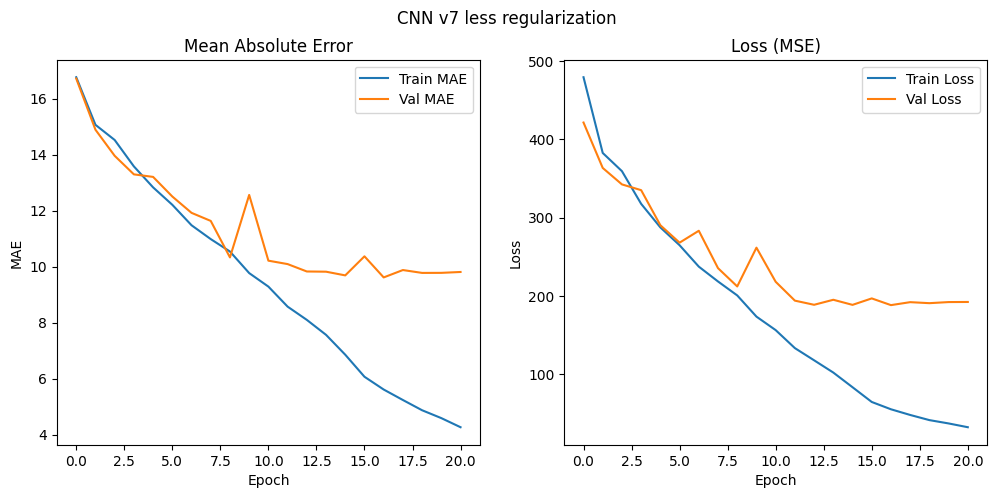

In [113]:
# Plot training & validation MAE/loss
plt.figure(figsize=(12,5))
plt.suptitle(model_name) #Titel boven je matplotlib-figuur
plt.subplot(1,2,1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict and show a few validation images with predicted and true ages
# preds = model.predict(X_val).flatten()

# fig, axes = plt.subplots(1, 5, figsize=(15,3))
# for i, ax in enumerate(axes):
#     ax.imshow(X_val[i])
#     ax.axis('off')
#     ax.set_title(f'True: {int(y_val[i])}\nPred: {int(preds[i])}')
# plt.tight_layout()
# plt.show()

In [114]:
def save_plot(figure, model_name):
    save_dir = 'validation_graphs'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # Vervang ongeldige tekens in de bestandsnaam
    safe_model_name = "".join([c for c in model_name if c.isalpha() or c.isdigit() or c in (' ', '-')]).rstrip()
    filename = f"{safe_model_name.replace(' ', '_')}.png"
    figure.savefig(os.path.join(save_dir, filename))
    print(f"Graph saved to {os.path.join(save_dir, filename)}")

# # Uncomment de volgende regel om de grafiek op te slaan
save_plot(plt.gcf(), model_name)

Graph saved to validation_graphs\CNN_v7_less_regularization.png


<Figure size 640x480 with 0 Axes>

### Base CNN-architectuur

```python
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])
```

**Visualisatie:**

<!-- ![Base CNN resultaten](./validation_graphs/base_cnn.png) -->

**Findings:**

Met enkel de base setup is er veel overfitting, de validation data performed niet zo goed als de train data. Ook zie ik dat er na 6 epochs nogsteeds verbetering mogelijk is dus meer epochs zouden nuttig zijn. De training tijd is al lang dus voor nu laat ik de epochs het zelfde. Mijn plan om langzaam aan een verbetering te proberen te krijgen zal als volgt zijn.

- Layers tweaken en het model complexer maken
- Activation functies tweaken
- Dropout
- Optimizers
- Regularization
- Meer epochs toevoegen met EarlyStopping (Dit als laatst om de max optimization proberen te krijgen nadat alle tweaks gedaan zijn)

Tussen door zal ik mijn stappen tracken


### CNN v2-architectuur

```python
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='linear')
])
```

**Visualisatie:**

<!-- ![Base CNN resultaten](./validation_graphs/CNN_v5_3_conv_layers__leaky_relu.png) -->

**Findings:**

Met meer complexiteit is het model al een stuk effectiever. Als volgende stap ga ik proberen nog meer layers toetevoegen om te zien hoeveel complexiteit het beste werkt

### CNN v3-architectuur

```python
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='linear')  #dit blijft 1 want we voorspellen 1 waarde (leeftijd)
])
```

**Visualisatie:**

<!-- ![Base CNN resultaten](./validation_graphs/CNN_v3_3_Extra_layer.png) -->

**Findings:**

Zelfs nog meer convolution toevoegen werkt nogsteeds voor verbetering. Meer dagen dan dit gaf geen benefit meer aan de performance waarschijnlijk omdat er te veel convolution gebruikt werd en de features te klein gemaakt werden waardoor er details verloren gingen. Daarom hou ik voor nu het aantal layers zo omdat het netwerk al erg diep is.

De volgende stap is om het model meer power te geven voor analyse van de features door een extra dense layer te gebruiken.

### CNN v4-architectuur

```python
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='linear')  #dit blijft 1 want we voorspellen 1 waarde (leeftijd)
])
```

**Visualisatie:**

<!-- ![Base CNN resultaten](./validation_graphs/CNN_v2_1_Extra_layer.png) -->

**Findings:**

So far the best version with the lowest error is still V3 but the new version with the leaky relu does have less overfitting happening. For this reason I think it might be best to add a small dropout now and keep training with more epochs until no more gain is achieved.



### CNN_v5_3_conv_layers__leaky_relu__dropout__earlystopping

```python
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(256),
    layers.LeakyReLU(alpha=0.1),
    layers.Dropout(0.1),
    layers.Dense(1, activation='linear')  #dit blijft 1 want we voorspellen 1 waarde (leeftijd)
])
```

**Visualisatie:**

<!-- ![Base CNN resultaten](./validation_graphs/CNN_v5_3_conv_layers__leaky_relu__dropout__earlystopping.png) -->

**Findings:**

It seems that the training is still netting improvement, but it is slowly overfitting still. For the next attempt I will add more dropout, a regularization and add more epochs to see how well I can train it given enough time.







### CNN_v6_more_regularization_and_50_epochs_max

```python
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(256),
    layers.LeakyReLU(alpha=0.1),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear')  #dit blijft 1 want we voorspellen 1 waarde (leeftijd)
])
```

**Visualisatie:**

<!-- ![Base CNN resultaten](./validation_graphs/CNN_v6_more_regularization_and_50_epochs_max.png) -->

**Findings:**

The new version with more dropout and a regularizer actually seems to perform worse than the last version. It seems it's now learning less from the data.

For the final solution I will remove the regulizer since it seems it might be to heavy. Tweak the dropout to 0.2 and try and add some layers.BatchNormalization(), after the conv layer. 



### CNN_v7_less_regularization

```python
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(256, kernel_regularizer=regularizers.l2(1e-4)),
    layers.LeakyReLU(alpha=0.1),
    layers.Dropout(0.3),
    layers.Dense(1, activation='linear')  #dit blijft 1 want we voorspellen 1 waarde (leeftijd)
])
```

**Visualisatie:**

<!-- ![Base CNN resultaten](./validation_graphs/CNN_v7_less_regularization.png) -->

**Findings:**

The batch normalization quickly showed that the model was getting worse, so I quickly removed that one again. After that I trained this version and it

## Conclusion

After testing various things, the conclusion is that the best performing model was CNN_v5_3_conv_layers__leaky_relu__dropout__earlystopping

But ultimately the differences between the different networks were not that big. The next thing to investigate is the changing of the data set.

Online I read that the biggest gain would be gotten from the input feature manipulation like doing color changes, mirroring the image and introducing random noise.



In [3]:
results = {
    'Base CNN': {'mae_train': [15.09432315826416,
                            14.00364875793457,
                            13.217229843139648,
                            12.561208724975586,
                            11.781421661376953,
                            10.994186401367188,
                            10.227398872375488],
              'mae_val': [14.556246757507324,
                          14.292440414428711,
                          13.544864654541016,
                          12.87238883972168,
                          13.170878410339355,
                          13.281801223754883,
                          12.514689445495605],
              'mse_train': [383.40081787109375,
                            330.20428466796875,
                            300.2842712402344,
                            272.8893737792969,
                            241.37030029296875,
                            209.6705322265625,
                            180.43405151367188],
              'mse_val': [373.9389343261719,
                          333.98150634765625,
                          313.4752502441406,
                          303.8142395019531,
                          302.8407897949219,
                          294.205322265625,
                          282.5218811035156]},
                          'CNN v2 (1 Extra layer)': {'mae_train': [15.54368782043457,
                                          14.297758102416992,
                                          13.444931030273438,
                                          12.530226707458496,
                                          11.746787071228027,
                                          11.027649879455566,
                                          10.369812965393066],
                            'mae_val': [15.52921199798584,
                                        15.06425952911377,
                                        13.069836616516113,
                                        12.840751647949219,
                                        12.228254318237305,
                                        12.109223365783691,
                                        11.678763389587402],
                            'mse_train': [411.9156494140625,
                                          344.34228515625,
                                          309.6745910644531,
                                          272.81298828125,
                                          242.15943908691406,
                                          215.1824493408203,
                                          189.90536499023438],
                            'mse_val': [374.5221862792969,
                                        354.5386047363281,
                                        306.9435119628906,
                                        291.09716796875,
                                        255.5399169921875,
                                        281.9854431152344,
                                        255.7533721923828]},
                                        'CNN v3 (3 Extra layers)': {'mae_train': [16.09134292602539,
                                           14.60921573638916,
                                           13.798316955566406,
                                           12.683573722839355,
                                           11.782254219055176,
                                           10.966657638549805,
                                           10.287933349609375],
                             'mae_val': [14.484198570251465,
                                         14.216069221496582,
                                         13.420161247253418,
                                         12.385590553283691,
                                         11.416098594665527,
                                         11.353998184204102,
                                         10.531935691833496],
                             'mse_train': [438.87066650390625,
                                           360.25262451171875,
                                           327.8085021972656,
                                           283.4713439941406,
                                           249.3455352783203,
                                           220.7265167236328,
                                           194.70936584472656],
                             'mse_val': [377.2528076171875,
                                         351.323486328125,
                                         302.685302734375,
                                         276.9634704589844,
                                         260.4814758300781,
                                         233.21803283691406,
                                         216.65516662597656]},
                                         'CNN v4 (3 conv layers, 2 dense layers)': {'mae_train': [15.99641227722168,
                                                          14.26630973815918,
                                                          13.447129249572754,
                                                          12.370826721191406,
                                                          11.442139625549316,
                                                          10.682855606079102,
                                                          9.966145515441895],
                                            'mae_val': [14.341448783874512,
                                                        13.997031211853027,
                                                        13.493265151977539,
                                                        15.48089599609375,
                                                        12.476921081542969,
                                                        10.586004257202148,
                                                        11.239415168762207],
                                            'mse_train': [433.06927490234375,
                                                          348.4216003417969,
                                                          313.81201171875,
                                                          272.582275390625,
                                                          238.7876434326172,
                                                          211.37208557128906,
                                                          185.9486846923828],
                                            'mse_val': [372.22137451171875,
                                                        335.62640380859375,
                                                        347.6602783203125,
                                                        348.79473876953125,
                                                        263.2198486328125,
                                                        234.5179443359375,
                                                        229.79872131347656]},
                                                        'CNN v5 (3 conv layers + leaky relu)': {'mae_train': [16.25336456298828,
                                                       14.756963729858398,
                                                       14.142498016357422,
                                                       13.540685653686523,
                                                       12.55992317199707,
                                                       11.691539764404297,
                                                       10.768097877502441],
                                         'mae_val': [16.196578979492188,
                                                     15.831990242004395,
                                                     13.593365669250488,
                                                     12.740463256835938,
                                                     12.070320129394531,
                                                     12.380340576171875,
                                                     10.95167350769043],
                                         'mse_train': [449.0156555175781,
                                                       368.3243408203125,
                                                       343.3647155761719,
                                                       318.254150390625,
                                                       275.63092041015625,
                                                       244.48516845703125,
                                                       211.46539306640625],
                                         'mse_val': [400.51849365234375,
                                                     388.5278015136719,
                                                     327.46990966796875,
                                                     298.81756591796875,
                                                     266.043701171875,
                                                     260.1516418457031,
                                                     229.25238037109375]},
                                                     'CNN v5 (3 conv layers + leaky relu + dropout + earlystopping)': {'mae_train': [16.113351821899414,
                                                                                 14.591817855834961,
                                                                                 13.743378639221191,
                                                                                 13.212301254272461,
                                                                                 12.447304725646973,
                                                                                 11.94031047821045,
                                                                                 11.105050086975098,
                                                                                 10.387941360473633,
                                                                                 9.7763032913208,
                                                                                 9.136086463928223,
                                                                                 8.635586738586426,
                                                                                 7.997185707092285,
                                                                                 7.416483402252197,
                                                                                 6.701735973358154,
                                                                                 5.935773849487305],
                                                                   'mae_val': [14.659022331237793,
                                                                               13.97337532043457,
                                                                               15.757184982299805,
                                                                               12.472983360290527,
                                                                               12.440780639648438,
                                                                               11.8516206741333,
                                                                               10.648682594299316,
                                                                               10.992719650268555,
                                                                               11.429405212402344,
                                                                               9.9131498336792,
                                                                               10.060951232910156,
                                                                               9.734228134155273,
                                                                               9.945541381835938,
                                                                               9.709440231323242,
                                                                               9.519278526306152],
                                                                   'mse_train': [440.7173156738281,
                                                                                 361.0523376464844,
                                                                                 325.1431884765625,
                                                                                 303.7339172363281,
                                                                                 270.2320861816406,
                                                                                 251.50611877441406,
                                                                                 221.69688415527344,
                                                                                 197.23464965820312,
                                                                                 175.12916564941406,
                                                                                 153.48745727539062,
                                                                                 137.27272033691406,
                                                                                 116.38993835449219,
                                                                                 99.25826263427734,
                                                                                 80.27404022216797,
                                                                                 62.04024124145508],
                                                                   'mse_val': [393.4153747558594,
                                                                               334.36163330078125,
                                                                               382.5669860839844,
                                                                               286.9665222167969,
                                                                               267.77587890625,
                                                                               253.5000457763672,
                                                                               223.38705444335938,
                                                                               220.57669067382812,
                                                                               227.50469970703125,
                                                                               198.91148376464844,
                                                                               194.8852081298828,
                                                                               197.66061401367188,
                                                                               194.7403106689453,
                                                                               189.60047912597656,
                                                                               184.90234375]},
                                                                               'CNN v6 more regularization and 50 epochs max': {'mae_train': [16.458223342895508,
                                                                14.92247200012207,
                                                                14.076809883117676,
                                                                13.504432678222656,
                                                                12.774559020996094,
                                                                11.879154205322266,
                                                                11.217083930969238,
                                                                10.69129467010498,
                                                                10.249308586120605,
                                                                9.552090644836426,
                                                                8.9893217086792,
                                                                8.468071937561035,
                                                                7.7214531898498535,
                                                                7.056905746459961,
                                                                6.423182964324951,
                                                                6.030714511871338,
                                                                5.525478839874268,
                                                                5.006937503814697,
                                                                4.73789644241333,
                                                                4.472222805023193,
                                                                4.382009983062744,
                                                                4.007283687591553],
                                                  'mae_val': [14.617300987243652,
                                                              14.192281723022461,
                                                              13.849778175354004,
                                                              12.889784812927246,
                                                              11.845178604125977,
                                                              12.082860946655273,
                                                              11.403861999511719,
                                                              10.827670097351074,
                                                              10.43707275390625,
                                                              10.2357177734375,
                                                              10.806241989135742,
                                                              10.159595489501953,
                                                              10.77908706665039,
                                                              10.078567504882812,
                                                              10.327662467956543,
                                                              10.483269691467285,
                                                              10.026043891906738,
                                                              9.876736640930176,
                                                              10.003174781799316,
                                                              10.182003021240234,
                                                              10.11755657196045,
                                                              10.258691787719727],
                                                  'mse_train': [459.6369934082031,
                                                                378.329345703125,
                                                                340.3507080078125,
                                                                314.7510986328125,
                                                                286.1636047363281,
                                                                251.60317993164062,
                                                                227.20529174804688,
                                                                207.5348663330078,
                                                                191.5428924560547,
                                                                166.5850372314453,
                                                                146.97314453125,
                                                                128.6609649658203,
                                                                106.57135772705078,
                                                                87.99919891357422,
                                                                72.15474700927734,
                                                                63.3614387512207,
                                                                52.79325866699219,
                                                                43.204410552978516,
                                                                38.96021270751953,
                                                                34.78396987915039,
                                                                34.05994415283203,
                                                                28.6383056640625],
                                                  'mse_val': [391.13525390625,
                                                              350.051513671875,
                                                              319.929931640625,
                                                              305.0647888183594,
                                                              263.3496398925781,
                                                              253.54315185546875,
                                                              238.17193603515625,
                                                              217.4311981201172,
                                                              209.97254943847656,
                                                              203.43524169921875,
                                                              211.1824188232422,
                                                              205.9665985107422,
                                                              207.41119384765625,
                                                              198.45474243164062,
                                                              210.53622436523438,
                                                              208.50741577148438,
                                                              204.59092712402344,
                                                              195.7569122314453,
                                                              199.32655334472656,
                                                              215.0732421875,
                                                              200.09060668945312,
                                                              201.7064208984375]},
                                                              'CNN v7 less regularization': {'mae_train': [16.7650089263916,
                                              15.065352439880371,
                                              14.523869514465332,
                                              13.58055591583252,
                                              12.831552505493164,
                                              12.209844589233398,
                                              11.479188919067383,
                                              10.984907150268555,
                                              10.5409574508667,
                                              9.77116870880127,
                                              9.288525581359863,
                                              8.573708534240723,
                                              8.10026741027832,
                                              7.566228866577148,
                                              6.856808662414551,
                                              6.069683074951172,
                                              5.613609790802002,
                                              5.239070415496826,
                                              4.873220443725586,
                                              4.592470169067383,
                                              4.2675557136535645],
                                'mae_val': [16.7165470123291,
                                            14.8902006149292,
                                            13.958809852600098,
                                            13.296241760253906,
                                            13.20571517944336,
                                            12.505313873291016,
                                            11.922142028808594,
                                            11.633903503417969,
                                            10.331232070922852,
                                            12.561790466308594,
                                            10.214539527893066,
                                            10.092691421508789,
                                            9.828558921813965,
                                            9.821014404296875,
                                            9.689189910888672,
                                            10.36950969696045,
                                            9.616423606872559,
                                            9.880036354064941,
                                            9.777565002441406,
                                            9.779533386230469,
                                            9.810818672180176],
                                'mse_train': [479.3101806640625,
                                              382.57427978515625,
                                              359.32269287109375,
                                              317.5761413574219,
                                              287.49346923828125,
                                              264.73553466796875,
                                              237.40414428710938,
                                              218.43260192871094,
                                              200.6237030029297,
                                              173.5607452392578,
                                              156.3331298828125,
                                              133.34117126464844,
                                              117.78107452392578,
                                              102.10601043701172,
                                              83.3855209350586,
                                              64.56246185302734,
                                              55.21986389160156,
                                              47.96812057495117,
                                              41.38218688964844,
                                              37.130523681640625,
                                              32.302764892578125],
                                'mse_val': [421.4373779296875,
                                            363.4326477050781,
                                            342.4290466308594,
                                            335.0587158203125,
                                            290.2490234375,
                                            268.01611328125,
                                            283.218994140625,
                                            235.43515014648438,
                                            212.11306762695312,
                                            261.6290283203125,
                                            218.06944274902344,
                                            193.9661102294922,
                                            188.67178344726562,
                                            195.075439453125,
                                            188.57005310058594,
                                            196.8189239501953,
                                            188.2421112060547,
                                            192.02598571777344,
                                            190.73818969726562,
                                            192.13858032226562,
                                            192.2712860107422]}
                                         
}

In [4]:
# Find the model with the lowest MAE in the validation set
lowest_mae = float('inf')
best_model = None

for model, metrics in results.items():
    min_mae = min(metrics['mae_val'])
    if min_mae < lowest_mae:
        lowest_mae = min_mae
        best_model = model

print(f"The model with the lowest MAE is '{best_model}' with a MAE of {lowest_mae:.4f}.")

The model with the lowest MAE is 'CNN v5 (3 conv layers + leaky relu + dropout + earlystopping)' with a MAE of 9.5193.


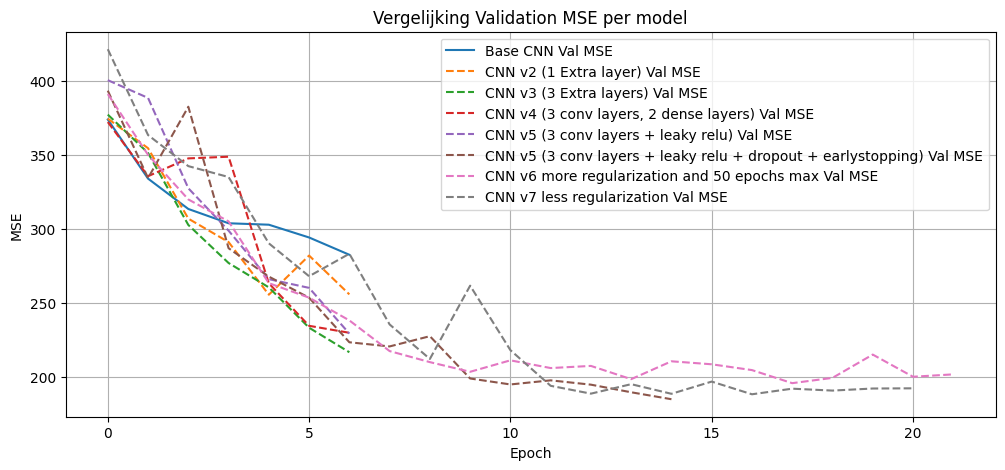

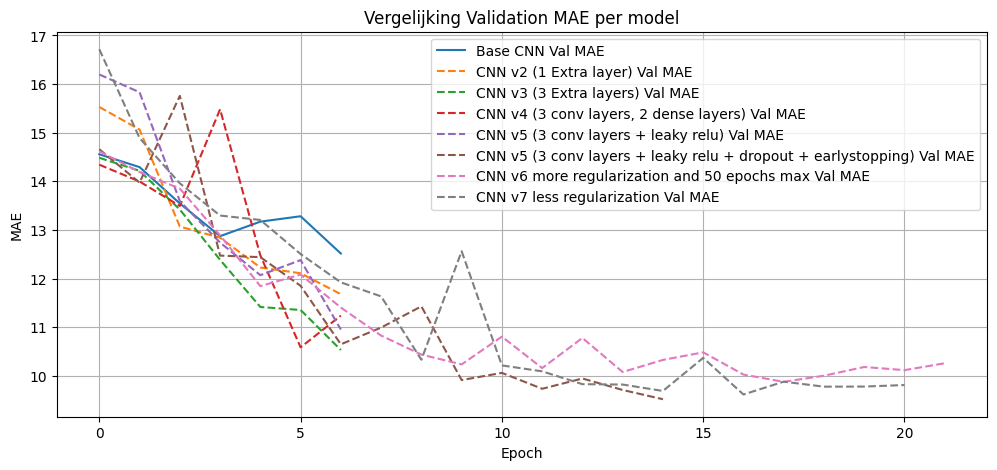

In [118]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

# Plot MSE
plt.figure(figsize=(12,5))
for model_name, data in results.items():
    linestyle = '-' if 'Base' in model_name else '--'
    plt.plot(data['mse_val'], label=f"{model_name} Val MSE", linestyle=linestyle)
plt.title("Vergelijking Validation MSE per model")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()

# Plot MAE
plt.figure(figsize=(12,5))
for model_name, data in results.items():
    linestyle = '-' if 'Base' in model_name else '--'
    plt.plot(data['mae_val'], label=f"{model_name} Val MAE", linestyle=linestyle)
plt.title("Vergelijking Validation MAE per model")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()